In [1]:
#import wget
import os
import glob
import random
import numpy as np
import os,shutil
import matplotlib 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from torch.utils.data import Dataset
from skimage.transform import resize
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms

In [2]:

mydir = r'C:\\Users\\炸酱面\\Downloads\\project\\warwick_qu_dataset_released_2016_07_08\\Warwick QU Dataset (Released 2016_07_08)'
pathDir =  os.listdir(mydir)   

In [3]:
# separate dataset to 3 class : testA, test B, train and its masks.
testsetA = []
testsetB = []
trainset = []
testmaskA = []
testmaskB = []
trainmask = []

for allDir in pathDir:      
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==True:     

        testmaskA.append(allDir)
        
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==False:
  
        testsetA.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==True:
       
        testmaskB.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==False:

        testsetB.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==True:
        
        trainmask.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==False:
        
        trainset.append(allDir)

#Build new dataset root  
newdir = os.getcwd()
raw_img_train_location = newdir+os.sep+'train'+os.sep+'raw'
raw_img_testA_location = newdir+os.sep+'testA'+os.sep+'raw'
raw_img_testB_location = newdir+os.sep+'testB'+os.sep+'raw'
anno_img_train_location = newdir+os.sep+'train'+os.sep+'anno'
anno_img_testA_location = newdir+os.sep+'testA'+os.sep+'anno'
anno_img_testB_location = newdir+os.sep+'testB'+os.sep+'anno'


if not os.path.isdir(raw_img_train_location):
    os.makedirs(raw_img_train_location)
if not os.path.isdir(raw_img_testA_location):
    os.makedirs(raw_img_testA_location)
if not os.path.isdir(raw_img_testB_location):
    os.makedirs(raw_img_testB_location)

if not os.path.isdir(anno_img_train_location):
    os.makedirs(anno_img_train_location)
if not os.path.isdir(anno_img_testA_location):
    os.makedirs(anno_img_testA_location)
if not os.path.isdir(anno_img_testB_location):
    os.makedirs(anno_img_testB_location)

def copy_img(path,list):
    for i in range(len(list)):
        new_obj_name = list[i]
        shutil.copy(mydir+'\\'+new_obj_name,path+'\\'+new_obj_name)

copy_img(raw_img_train_location,trainset)
copy_img(raw_img_testA_location,testsetA) 
copy_img(raw_img_testB_location,testsetB)
copy_img(anno_img_train_location,trainmask)
copy_img(anno_img_testA_location,testmaskA)
copy_img(anno_img_testB_location,testmaskB)
    
    

In [4]:
# sort the dataset to make raw images and its masks are corresponding.

def namesort(path,way):
    # 0 for raw, 1 for anno
    labelList = []  # 类标签列表
    datasetList = listdir(path)
    datasetload = []
    if way==0:
        list.sort(datasetList,key=lambda x: int(x[6:-4]))
    else:
        list.sort(datasetList,key=lambda x: int(x[6:-9]))
    for i in range(len(datasetList)):
        temp=imread(path+"\\"+datasetList[i])
        datasetload.append(temp)
    return datasetList,datasetload

(testsetA,testsetAraw) = namesort("testA/raw",0)
(testmaskA,testmaskAanno) = namesort("testA/anno",1)
(testsetB,testsetBraw) = namesort("testB/raw",0)
(testmaskB,testmaskBanno) = namesort("testB/anno",1)
(trainset,trainsetraw) = namesort("train/raw",0)
(trainmask,trainmaskanno) = namesort("train/anno",1)


In [5]:
#crop images to get larger dataset.

newdir = os.getcwd()

raw_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'raw'
raw_img_testA_cropped_location = newdir+os.sep+'testA'+os.sep+'cropped'+os.sep+'raw'
raw_img_testB_cropped_location = newdir+os.sep+'testB'+os.sep+'cropped'+os.sep+'raw'
anno_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'anno'
anno_img_testA_cropped_location = newdir+os.sep+'testA'+os.sep+'cropped'+os.sep+'anno'
anno_img_testB_cropped_location = newdir+os.sep+'testB'+os.sep+'cropped'+os.sep+'anno'


if not os.path.isdir(raw_img_train_cropped_location):
    os.makedirs(raw_img_train_cropped_location)
if not os.path.isdir(raw_img_testA_cropped_location):
    os.makedirs(raw_img_testA_cropped_location)
if not os.path.isdir(raw_img_testB_cropped_location):
    os.makedirs(raw_img_testB_cropped_location)

if not os.path.isdir(anno_img_train_cropped_location):
    os.makedirs(anno_img_train_cropped_location)
if not os.path.isdir(anno_img_testA_cropped_location):
    os.makedirs(anno_img_testA_cropped_location)
if not os.path.isdir(anno_img_testB_cropped_location):
    os.makedirs(anno_img_testB_cropped_location)



def crop_img(raw_picture,anno_picture,crop_size,path1,path2):
    count =0
    ##raw_picture：raw images, anno_picture:anno images，path1:raw path，path2:anno path
    for i in range(len(raw_picture)):
        for j in range(2):
            raw_img = raw_picture[i]
            anno_img = anno_picture[i]
            x_shape = raw_img.shape[0]-crop_size
            y_shape = raw_img.shape[1]-crop_size
            x1 = random.randint(0,int(x_shape/2))
            x2 = random.randint(int(x_shape/2),x_shape)
            y1 = random.randint(0,int(y_shape/2))
            y2 = random.randint(int(y_shape/2),y_shape)
            if j == 0:
                cropped_raw_img = raw_img[x1:x1+crop_size,:]
                cropped_raw_img = cropped_raw_img[:,y1:y1+crop_size]
                cropped_anno_img = anno_img[x1:x1+crop_size,:]
                cropped_anno_img = cropped_anno_img[:,y1:y1+crop_size]
            else:
                cropped_raw_img = raw_img[x2:x2+crop_size,:]
                cropped_raw_img = cropped_raw_img[:,y2:y2+crop_size]
                cropped_anno_img = anno_img[x2:x2+crop_size,:]
                cropped_anno_img = cropped_anno_img[:,y2:y2+crop_size]
            if cropped_anno_img.shape[0]!=400 or cropped_anno_img.shape[1]!=400:
                print('error')
            count = count+1
            Image.fromarray(cropped_raw_img).save(path1+os.sep+str(count)+'.png')
            Image.fromarray(cropped_anno_img).save(path2+os.sep+str(count)+'.png')
    
    list1 = os.listdir(path1)
    list2 = os.listdir(path2)
    
    return list1,list2 

[testsetA,testmaskA]=crop_img(testsetAraw,testmaskAanno,400,raw_img_testA_cropped_location,anno_img_testA_cropped_location)
[testsetB,testmaskB]=crop_img(testsetBraw,testmaskBanno,400,raw_img_testB_cropped_location,anno_img_testB_cropped_location)
[trainset,trainmask]=crop_img(trainsetraw,trainmaskanno,400,raw_img_train_cropped_location,anno_img_train_cropped_location)


In [6]:
#IMAGE AUGMENTATION 
transform = transforms.Compose(
    [transforms.ToTensor()]
)



def batch_generator(img_list, anno_list, batch_size, num_of_classes=2,transfrom=transform):
    images=[]
    annos=[]
    for i in range(batch_size):
#         rand_int = random.randint(0, len(img_list)-1)
        rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))
#         data=range(len(img_list))
#         rand_int=data.sample(n=1, replace=False)
        img = np.array(Image.open(img_list[rand_int]))
        img=transform(img)
        img=np.array(img)
        images.append(img)
        anno = np.array(Image.open(anno_list[rand_int]).convert("L"))
        anno[anno>0] = 1
        anno_reshaped = np.zeros((anno.shape[0], anno.shape[1], num_of_classes))
    
        for i in range(num_of_classes):

            anno_reshaped[:, :, i][anno == i] = 1
        
        annos.append(anno_reshaped)
        
    images=np.array(images)
    annos=np.array(annos)


    return images, annos
    
    

path_to_images = 'C:\\Users\\炸酱面\\Downloads\\project\\train\\cropped\\raw'
path_to_annotations = 'C:\\Users\\炸酱面\\Downloads\\project\\train\\cropped\\anno'
img_list = sorted(trainset)
anno_list = sorted(trainmask)
img_list = glob.glob(path_to_images+os.sep+"*.png")
anno_list = glob.glob(path_to_annotations+os.sep+"*.png")


path_to_testA = 'C:\\Users\\炸酱面\\Downloads\\project\\testA\\cropped\\raw'
path_to_annoA = 'C:\\Users\\炸酱面\\Downloads\\project\\testA\\cropped\\anno'
testA_list = sorted(testsetA)
annoA_list = sorted(testmaskA)
testA_list = glob.glob(path_to_images+os.sep+"*.png")
annoA_list = glob.glob(path_to_annoA+os.sep+"*.png")

batch_size=5
images, annos = batch_generator(img_list, anno_list,batch_size, 2)


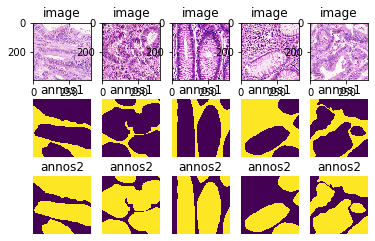

In [7]:
images = torch.from_numpy(images)
for k in range(batch_size):
    
    imshow = images.permute(0,2,3,1)
    plt.subplot(3, 5, k+1)
    plt.imshow(imshow[k,:,:,:])
    plt.title('image')
    plt.subplot(3, 5, k+6)
    plt.imshow(annos[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 5, k+11)
    plt.imshow(annos[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

In [8]:
#check batch and show some data

#images = torch.from_numpy(images)
annos = torch.from_numpy(annos)
annos = annos.permute(0,3,1,2)
print(images.shape)
print(annos.shape)


# plt.imshow(images[1,:,:,:])
# plt.imshow()
# plt.imshow(images[1,:,:,:])




torch.Size([5, 3, 400, 400])
torch.Size([5, 2, 400, 400])


In [9]:

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(400)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 2, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        d3 = torch.sigmoid(d3)
        return d3
    
    

In [10]:
net=SegNet()
print(net)

SegNet(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bottleneck_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample0): Upsample(size=32, mode=nearest)
  (dec_conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): Upsample(size=64, mode=nearest)
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [11]:
import torch.optim as optim

#criterion = nn.BCELoss() 

optimizer = optim.SGD(net.parameters(), lr=0.01)#,momentum=0.9,weight_decay=1e-4)

def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))


In [12]:
num_epoch = 2 
steps=34

# steps = 3 
for epoch in range(num_epoch):  
    running_loss = 0.0
    avg_loss=0.0
    print('* Epoch %d/%d' % (epoch+1, num_epoch))
    net.train()
 
    for step in range(steps):
        images, annos = batch_generator(img_list, anno_list,batch_size, 2)
        images = torch.from_numpy(images)
        annos = torch.from_numpy(annos)
        annos = annos.float()
        annos = annos.permute(0,3,1,2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = bce_loss(annos, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.data 

        if step < 34:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss / batch_size))
        running_loss = 0.0
#       avg_loss += loss / steps
#     print(' -- loss: %f' % avg_loss)       

#     clear_output(wait=True)
    imgtest, annosA = batch_generator(testA_list, annoA_list,batch_size, 2)
    net.eval()  # testing mode
    Y_hat = F.sigmoid(model(imgteat.to(device))).detach().cpu()
    imshow=imgtest.permute(0,2,3,1)
    outshow=Y_hat.permute(0,2,3,1)
    
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow[k,:,:,:])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Output1')
        plt.axis('off')
        
        plt.subplot(3,3,k+7)
        plt.imshow(outshow[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Output2')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, num_epoch, avg_loss))
    plt.show()
print('Finished Training')

* Epoch 1/2
[1,     1] loss: 0.145
[1,     2] loss: 0.145
[1,     3] loss: 0.145
[1,     4] loss: 0.145
[1,     5] loss: 0.145
[1,     6] loss: 0.145
[1,     7] loss: 0.145
[1,     8] loss: 0.145
[1,     9] loss: 0.145
[1,    10] loss: 0.145


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1843200000 bytes. Buy new RAM!
